In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import imutils
from shapely.geometry import Point, Polygon

import yolo3_one_file_to_detect_them_all as yolo3
import YOLOV3 as yolo3_custom
from keras.models import load_model

import progressbar
from datetime import datetime

%matplotlib inline

# Player Tracking

In [2]:
model = yolo3.make_yolov3_model()
weight_reader = yolo3.WeightReader('./data/weights/yolov3.weights')
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [3]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person"]

In [4]:
PATH = './data/xu_tomokazu_bank_of_communications_2020_set_1.mp4'
scaling_factor = 0.5

cap = cv2.VideoCapture(PATH)
ret, img = cap.read()
new_h, new_w = int(img.shape[1]*scaling_factor), int(img.shape[0]*scaling_factor)
img = cv2.resize(img, (new_h, new_w), interpolation=cv2.INTER_AREA)
h, w, _ = img.shape

In [5]:
src_pts = np.array([
    [1, 86], 
    [1, 326], 
    [413, 326], 
    [413, 86]
])

dst_pts = np.array([
      [1,  1],     
      [1,  413],    
      [415,  415],    
      [415,  1],  
    ])

In [6]:
def drawPlayers(im, pred_boxes, pred_classes, showResult=False):
    
    color = [255, 0, 0]
    thickness = 3
    radius = 3

    i  = 0
    for box in pred_boxes:

        # Include only class Person
        ##if pred_classes[i] == 'Person':  

        x1 = int(box.xmin)
        y1 = int(box.ymin)
        x2 = int(box.xmax)
        y2 = int(box.ymax)

        xc = x1 + int((x2 - x1)/2)
        player_pos = (xc - 1, y2 - 25)

        court = Polygon(src_pts)

        # Draw only players that are within the court
        if (box.classes[0] > obj_thresh) & (Point(player_pos).within(court)):
            # ignore the umpire on the left side
            if xc == 21 and y2 == 205:
                continue
            if showResult:
                print("[% 3d, % 3d]" %(xc, y2))

            cv2.circle(im, player_pos, radius, color, thickness)
            i = i + 1            

    if showResult:
        plt.imshow(im)
#         cv2.imshow('Court', im)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()        

person: 75.28159618377686%
person: 95.3445315361023%


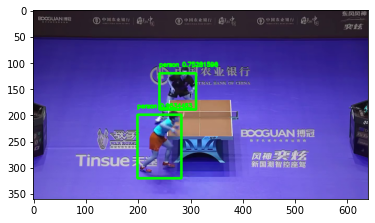

In [7]:
img_copy = yolo3.preprocess_input(img, net_h, net_w)
preds = model.predict(img_copy)
bboxes = []

for i in range(len(preds)):
    bboxes += yolo3.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

yolo3.correct_yolo_boxes(bboxes, h, w, net_h, net_w)
yolo3.do_nms(bboxes, nms_thresh)
obj = yolo3.draw_boxes(img, bboxes, labels, obj_thresh)

plt.imshow(img)
# cv2.imshow('YOLO prediction', img)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

[ 276,  189]
[ 241,  320]


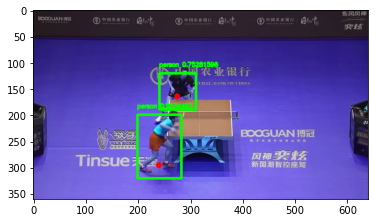

In [8]:
drawPlayers(obj, bboxes, labels, showResult=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


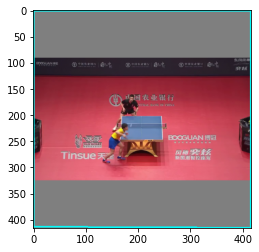

In [9]:
im_poly = img_copy[0].copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [dst_pts], isClosed=True, color=[0,255,255], thickness=2)
plt.imshow(im_poly)
# cv2.imshow('Court', im_poly)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [10]:
def homographyTransform(img_src, img_dst, showResult=False):

    # Calculate Homography
    h, status = cv2.findHomography(src_pts, dst_pts)
    img_out = cv2.warpPerspective(img_src, h, (img_dst.shape[1], img_dst.shape[0]))
    
    if showResult:
        plt.imshow(img_out)
#         cv2.imshow('Court', img_out)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

    return img_out

def getPlayersMask(im):
    lower_range = np.array([255,0,0])                         # Set the Lower range value of blue in BGR
    upper_range = np.array([255,155,155])                     # Set the Upper range value of blue in BGR
    mask = cv2.inRange(im, lower_range, upper_range)          # Create a mask with range
    result = cv2.bitwise_and(im, im, mask = mask)             # Performing bitwise and operation with mask in img variable
    # cv2_imshow(result)                              

    return cv2.inRange(result, lower_range, upper_range)  

(360, 640, 3)

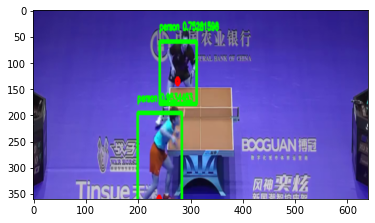

In [11]:
court = cv2.imread('./data/table_tennis_court_2.png')
court = cv2.resize(court, (w,h))

img_homography = homographyTransform(img, court, showResult=True)
img_homography.shape

In [12]:
court.shape

(360, 640, 3)

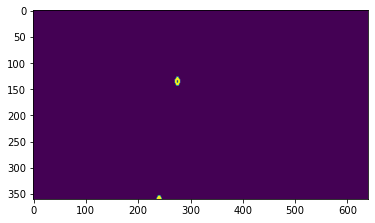

In [13]:
mask = getPlayersMask(img_homography)
plt.imshow(mask)

In [14]:
def drawPlayersOnCourt(im, coord, color, radius=10):
    for player_pos in coord:
        center = (player_pos[0], player_pos[1])
        cv2.circle(im, center, radius, color, thickness=-1)
        
    return im

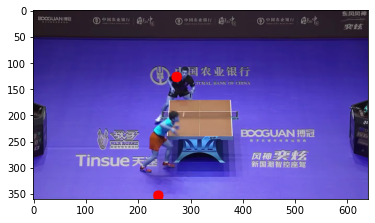

In [15]:
contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

color = [255,0,0]

if contours is not None:
#     print('masuk')
    for cont in contours:
        res = drawPlayersOnCourt(court, cont[0], color)
        
plt.imshow(court)
plt.show()
# cv2.imshow('court', court)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [16]:
PATH = './data/xu_tomokazu_bank_of_communications_2020_set_1.mp4'
scaling_factor = 0.5

cap = cv2.VideoCapture(PATH)
ret, img = cap.read()
new_h, new_w = int(img.shape[0]*scaling_factor), int(img.shape[1]*scaling_factor)
new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

player_info = {'player_A': {'label': 'Player A', 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
               'player_B': {'label': 'Player B', 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
              }

n_frame = 1
bboxes = []

img_h, img_w, _ = new_img.shape
input_img = yolo3_custom.preprocess_input(new_img, net_h, net_w)
preds = model.predict(input_img)

for i in range(len(preds)):
    bboxes += yolo3_custom.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
    
yolo3_custom.correct_yolo_boxes(bboxes, img_h, img_w, net_h, net_w)
yolo3_custom.do_nms(bboxes, nms_thresh)
image = yolo3_custom.draw_boxes(new_img, n_frame, bboxes, labels, obj_thresh, src_pts, player_info, player=player_info['player_A']['label'])

In [17]:
player1 = 'Xu Xin'
player_info['player_A']['coords'] = player1

In [18]:
cv2.imshow('player', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ 276,  189]
[ 241,  320]


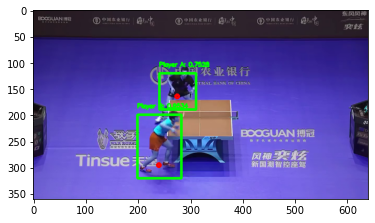

In [19]:
drawPlayers(image, bboxes, labels, showResult=True)

In [ ]:
vid_path = './data/xu_tomokazu_bank_of_communications_2020_set_1.mp4'
save_path = './data/ml_fzd_bank_of_communications_final_2020.mp4'

cap = cv2.VideoCapture(vid_path)

video_FourCC = int(cap.get(cv2.CAP_PROP_FOURCC))
video_fps    = cap.get(cv2.CAP_PROP_FPS)
video_size   = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = n_frames / video_fps

writer = None
grabbed = True
frame_number = 0

PLAYER_1 = 'Xu Xin'
PLAYER_2 = 'Tomokazu Harimoto'
player_info = {'player_A': {'label': PLAYER_1, 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
               'player_B': {'label': PLAYER_2, 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
              }

court_img = cv2.imread('./data/table_tennis_court.png')
color = (255,0,0)

bar = progressbar.ProgressBar(maxval=n_frames, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
# start_time = datetime.now()

coordinates = []
while grabbed:
    frame_number += 1
    grabbed, frame = cap.read()
    
    if writer == None:
        writer = cv2.VideoWriter(save_path, video_FourCC, video_fps, (court_img.shape[1], court_img.shape[0]), True)
        
    if grabbed:
        # image scaling
        scaling_factor = 0.5
        new_h, new_w = int(frame.shape[1]*scaling_factor), int(frame.shape[0]*scaling_factor)
        frame = cv2.resize(frame, (new_h, new_w), interpolation=cv2.INTER_AREA)
        h, w, _ = frame.shape
        
        # players' positions
        frame_h, frame_w, _ = frame.shape
        new_frame = yolo3_custom.preprocess_input(frame, net_h, net_w)
        
        preds = model.predict(new_frame)
        bboxes = []
        for i in range(len(preds)):
            bboxes += yolo3_custom.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
        
        yolo3_custom.correct_yolo_boxes(bboxes, frame_h, frame_w, net_h, net_w)
        yolo3_custom.do_nms(bboxes, nms_thresh)
        frame = yolo3_custom.draw_boxes(frame, frame_number, bboxes, labels, obj_thresh, src_pts, player_info, player=player_info['player_A']['label'])
        
        # court
#         court_copy = court_img.copy()
#         drawPlayers(frame, bboxes, labels, showResult=False)
#         homography_frame = homographyTransform(frame, court_copy, showResult=False)
#         player_mask = getPlayersMask(homography_frame)
        
#         contours = cv2.findContours(player_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         contours = imutils.grab_contours(contours)
#         if contours is not None:
#             for c in contours:
#                 res = drawPlayersOnCourt(court_copy, c[0], color)
#                 coordinates.append(c[0])

        # write to video
#         writer.write(res)

        bar.update(frame_number)
                
        cv2.imshow('Final Result', frame)
        
        if cv2.waitKey(1) & 0XFF == ord('q'):
            break
            
    else:
        grabbed = False
        
# cv2.imshow('Result', res)
# data = pd.DataFrame(np.squeeze(coordinates), columns=['player_x', 'player_y'])
# data.to_csv('./data/ml_fzd_bank_of_communications_final_2020.csv')

# print("Finished")
# print("Elapsed time:", datetime.now() - start_time)
# writer.release()
cap.release()
cv2.destroyAllWindows()

[16 15 40]
frame: 2 .. player: Xu Xin .. torso_frame: [[16 15 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.01004888913107 .. cos_sim_B: 125.45669437210344
[ 39 215 246]
frame: 2 .. player: Tomokazu Harimoto .. torso_frame: [[ 39 215 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 111.39285532834396 .. cos_sim_B: 12.704504322127365
[19 15 34]
frame: 3 .. player: Xu Xin .. torso_frame: [[19 15 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.47301128745635 .. cos_sim_B: 130.77804599521687
[ 15 110 170]
frame: 3 .. player: Tomokazu Harimoto .. torso_frame: [[ 15 110 170]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 81.60719847223532 .. cos_sim_B: 41.46963374581813
[19 15 34]
frame: 4 .. player: Xu Xin .. torso_frame: [[19 15 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.47301128745635 .. cos_sim_B: 130.77804599521687
[ 19 118 166]
frame: 4 .. player: Tomokaz

[20 18 30]
frame: 32 .. player: Xu Xin .. torso_frame: [[20 18 30]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.31731201339821 .. cos_sim_B: 123.11211101887771
[ 30 238 253]
frame: 32 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 238 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.32151085101846 .. cos_sim_B: 22.07861436347138
[22 20 32]
frame: 33 .. player: Xu Xin .. torso_frame: [[22 20 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.75301752725045 .. cos_sim_B: 121.15981507997562
[ 30 242 253]
frame: 33 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 242 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.38275667310123 .. cos_sim_B: 23.930538588308337
[24 22 34]
frame: 34 .. player: Xu Xin .. torso_frame: [[24 22 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.37921274560725 .. cos_sim_B: 119.27136481509741
[ 26 253 246]
frame: 34 .. player: 

[27 21 47]
frame: 63 .. player: Xu Xin .. torso_frame: [[27 21 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.87468627675602 .. cos_sim_B: 129.84778374924647
[ 36 227 240]
frame: 63 .. player: Tomokazu Harimoto .. torso_frame: [[ 36 227 240]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.93366255597117 .. cos_sim_B: 20.737045140343213
[26 20 44]
frame: 64 .. player: Xu Xin .. torso_frame: [[26 20 44]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.55077715664977 .. cos_sim_B: 130.51842406954032
[ 40 224 238]
frame: 64 .. player: Tomokazu Harimoto .. torso_frame: [[ 40 224 238]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.83705364156548 .. cos_sim_B: 19.868703358932873
[26 14 48]
frame: 65 .. player: Xu Xin .. torso_frame: [[26 14 48]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 50.13848831254221 .. cos_sim_B: 138.5740761698166
[ 43 230 248]
frame: 65 .. player: 